# **Part 2: Machine Learning**

# CHALLENGE : predict conversions 🏆🏆

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

# Choose necessary variables

In [2]:
data = pd.read_csv('Data/conversion_data_train.csv')
data = data[data['age'] <= 100]
# data_sample = data.sample(10000)

In [3]:
target_variable = 'converted'
Y = data.loc[:, target_variable]

Here we want to check which variables we will further use to test our models. We know from EDA that total_pages_visited seems the most important variable. So we will try to train our model with only this variable, check the f1 score for the train and test, and then add other variables one by one to see if they improve the f1 scores or not. We first add new_user then age, which seemed the most important after the number of pages visited. In each case, we define a new list of features, then a list of numeric_indices and a list of categorical_indices. Then we define the X dataset to work with.

In [4]:
# Defining features, and features type (numerical/categorical)
features_list = ['total_pages_visited','new_user','age','country','source']
numeric_indices = [0,2]
categorical_indices = [1,3,4]

# Creating several lists of features for our variable study (1 variable, then 2, then 3... then 5)
features_lists = [features_list[:i+1] for i in range(len(features_list))]

# Locate the X dataset in each subset
X_list = [data.loc[:, sublist] for sublist in features_lists]
print("Dataset with only 1 variable: ")
print(X_list[0])
print("")
print("Dataset with 5 variables :")
print(X_list[4])
print("")

# Numeric and categorical indices for each subset
numeric_indices_list = [[i for i in numeric_indices if i in range(len(sublist))] for sublist in features_lists]
categorical_indices_list = [[i for i in categorical_indices if i in range(len(sublist))] for sublist in features_lists]

for i,num,cat in zip(range(5),numeric_indices_list,categorical_indices_list):
    print("Subset with ", i, "variables: Numerical indices: ",num,"; Categorical indices: ",cat)

Dataset with only 1 variable: 
        total_pages_visited
0                         2
1                         3
2                        14
3                         3
4                         3
...                     ...
284575                    1
284576                    2
284577                    5
284578                    4
284579                    3

[284578 rows x 1 columns]

Dataset with 5 variables :
        total_pages_visited  new_user  age  country  source
0                         2         1   22    China  Direct
1                         3         1   21       UK     Ads
2                        14         0   20  Germany     Seo
3                         3         1   23       US     Seo
4                         3         1   28       US  Direct
...                     ...       ...  ...      ...     ...
284575                    1         1   36       US     Ads
284576                    2         1   31       US     Seo
284577                    5         1 

Here we define the transformers that will be used during preprocessing.

In [5]:
numeric_transformer = StandardScaler() # for numeric features
categorical_transformer = OneHotEncoder(drop="first") # for categorical features

Now, for each subset (1 or 2 or.. 5 variables), we divide the subset in train and test data, we preprocess them, we run the simplest model (as the target is caterogical), a logistic regression, we make predictions and we assess the model with f1-score (used for categorical target in a regression).

In [6]:
# Initialize lists to store results
variables = []
f1_train_scores = []
f1_test_scores = []
precision_scores = []
std_deviations = []

for X, numeric_indices, categorical_indices in zip(X_list, numeric_indices_list, categorical_indices_list):
    
    # Dividing the dataset in train and test (we use stratify as the target variable is not heavenly distributed)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify=Y)

    # Applying pipeline on X variables depending on columns
    feature_encoder = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_indices),
            ('num', numeric_transformer, numeric_indices)
        ]
    )
    X_train = feature_encoder.fit_transform(X_train)
    X_test = feature_encoder.transform(X_test)

    # Train the dataset and make predictions
    classifier = LogisticRegression()
    classifier.fit(X_train, Y_train)
    Y_train_pred = classifier.predict(X_train)
    Y_test_pred = classifier.predict(X_test)

    # Calculate scores and precision
    f1_train = np.round(f1_score(Y_train, Y_train_pred), 4)
    f1_test = np.round(f1_score(Y_test, Y_test_pred), 4)
    scores = cross_val_score(classifier, X_train, Y_train, cv=10)
    precision = np.round(scores.mean(), 4)
    std_dev = np.round(scores.std(), 6)

    # Store results in lists
    variables.append(len(numeric_indices) + len(categorical_indices))
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    precision_scores.append(precision)
    std_deviations.append(std_dev)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Variables': variables,
    'F1 Score (Train)': f1_train_scores,
    'F1 Score (Test)': f1_test_scores,
    'Precision': precision_scores,
    'Standard Deviation': std_deviations
})

print(results_df)

   Variables  F1 Score (Train)  F1 Score (Test)  Precision  Standard Deviation
0          1            0.6950           0.6961     0.9830            0.000950
1          2            0.7273           0.7333     0.9844            0.000581
2          3            0.7425           0.7424     0.9852            0.000689
3          4            0.7619           0.7671     0.9862            0.000742
4          5            0.7626           0.7712     0.9862            0.000771


Every variable added to total_pages_visited is improving the f1-score of the train and test sets. So we confirm that we will use the 5 of them when testing our models later.

# Baseline Logistic Regression

Now, we redefine the final dataset (all 5 features taken into account) and we develop the best logistic regression possible using a gridsearch.

In [7]:
# Re-defining the dataset with the option chosen: 5 variables
features_list = ['total_pages_visited','new_user','age','country','source']
numeric_indices = [0,2]
categorical_indices = [1,3,4]
X = data.loc[:, features_list]
# I don't need to redefine Y and repreprocess it
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

feature_encoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),
        ('num', numeric_transformer, numeric_indices)
    ]
)
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test) # Don't fit again !!

In [8]:
model = {
        'name': 'Logistic Regression',
        'model': LogisticRegression(),
        'params': 
            {
            'penalty': ['l1', 'l2'],                                    # Regularization type
            'C': [0.01, 0.1, 1.0, 10.0, 100, 1000, 5000, 8000],         # Inverse of regularization strength
            'solver': ['liblinear', 'lbfgs','newton-cg','sag','saga'],  # Optimization algorithm for smaller datasets
            'max_iter': [100, 200, 500, 1000, 5000],                    # Maximum number of iterations to converge
            'tol': [1e-3, 1e-4, 1e-5],                                  # Tolerance for stopping criteria
            }
        }

In [ ]:
%%time

results = [] # This is where we will save all models with metrics

grid_search = GridSearchCV(model['model'], model['params'], cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Evaluation and storage of performance in a variable "results"
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
f1_train = np.round(f1_score(Y_train, train_preds), 4)
f1_test = np.round(f1_score(Y_test, test_preds), 4)
# scores = cross_val_score(model, X_train, Y_train, cv=10)
# precision = np.round(scores.mean(), 4)
# std_dev = np.round(scores.std(), 6)
accuracy_train = accuracy_score(Y_train, train_preds)
accuracy_test = accuracy_score(Y_test, test_preds)
recall = recall_score(Y_test, test_preds)
auc_roc = roc_auc_score(Y_test, test_preds)

# Store the best logistic regression model in the variable "results" where we will store all models metrics later
results.append({'Model': model['name'],
                'F1 Train': f1_train,
                'F1 Test': f1_test,
                # 'Precision': precision,
                # 'Std Dev': std_dev,
                'Train Accuracy': accuracy_train,
                'Test Accuracy': accuracy_test,
                'Recall': recall,
                'AUC-ROC': auc_roc,
                'Best Model': best_model,
                'Best Params': best_params,
                'Train Preds': train_preds,
                'Test Preds': test_preds
                })

We can have a look at our gridsearch in order to see what were the best parameters.

In [ ]:
cv_results = grid_search.cv_results_

grid_search_results = pd.DataFrame(columns=['Model', 'Mean F1 Score', 'Parameters'])

for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    grid_search_results = grid_search_results.append({
        'Model': model['name'],
        'Mean F1 Score': mean_score,
        'Parameters': params
    }, ignore_index=True)

In [15]:
sorted_logistic_regressions = grid_search_results.sort_values(by='Mean F1 Score', ascending=False)
pd.set_option('display.max_colwidth', None)
display(sorted_logistic_regressions.head(20))

,Model,Mean F1 Score,Parameters
684,Logistic Regression,0.763735,"{'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}"
882,Logistic Regression,0.763712,"{'C': 1000, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"
1164,Logistic Regression,0.763698,"{'C': 8000, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}"
822,Logistic Regression,0.763680,"{'C': 1000, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"
1194,Logistic Regression,0.763677,"{'C': 8000, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}"
1122,Logistic Regression,0.763654,"{'C': 8000, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"
1105,Logistic Regression,0.763654,"{'C': 8000, 'max_iter': 200, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.0001}"
1062,Logistic Regression,0.763647,"{'C': 8000, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"
432,Logistic Regression,0.763647,"{'C': 1.0, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"
312,Logistic Regression,0.763646,"{'C': 1.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}"


We notice here that if the first quick logistic regression made earlier, we had test score of 0.7712, whereas here the best score from the gridsearch is only 0.763792. This is easily explained by the fact that there was no cross validation made before whereas we do a gridsearch with a cv=10 now, which is much more accurate. We can see that we get various best parameters (various C, both penalty l1 and l2, various max_iter and tol). Only the solver is quite redundant here (sag, sag or liblinear). 

# Testing more models

Now that we have a baseline, the idea is to test more models to see if we can improve the f1 score.

In [12]:
# Models to be tested

models = [
    {
        'name': 'SVM Linear',
        'model': SVC(kernel='linear', probability=True),
        'params': {} 
    },
    {
        'name': 'SVM RBF',
        'model': SVC(kernel='rbf', probability=True),
        'params': {}
    },
    {
        'name': 'SVM Poly (3)',
        'model': SVC(kernel='poly', degree=3, probability=True),
        'params': {}
    },
    {
        'name': 'Decision Tree Entropy',
        'model': DecisionTreeClassifier(criterion="entropy"),
        'params': {
            'max_depth': [4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'Decision Tree Gini',
        'model': DecisionTreeClassifier(criterion="gini"),
        'params': {
            'max_depth': [4, 6, 8, 10],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [1, 2, 4, 8],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 4, 8]
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [100, 150],  # Reduced from [100, 150, 300]
            'learning_rate': [0.1, 0.01],  # Reduced from [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
            'max_depth': [4, 5],  # Reduced from [4, 5, 6, 7, 10]
            'min_child_weight': [1],  # Only one value
            # 'gamma': [0, 0.1, 0.2]
        }
    },
    {
        'name': 'CatBoost',
        'model': CatBoostClassifier(),
        'params': {
            'n_estimators': [1000],  # Reduced from [1000, 5000]
            'learning_rate': [0.1],  # Reduced from [0.01, 0.05, 0.1, 0.5, 1]
            'depth': [6],  # Only one value
        }
    },
]


In [ ]:
%%time

# Iterate over models, doing a gridsearch for choosing the best params for each model. 
for model in models:
    model_name = model['name']
    model_type = model['model']
    params = model['params']
    grid_search = GridSearchCV(model_type, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, Y_train)

    # Evaluation and storage of performance in a variable "results"
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    f1_train = np.round(f1_score(Y_train, train_preds), 4)
    f1_test = np.round(f1_score(Y_test, test_preds), 4)
    # scores = cross_val_score(model, X_train, Y_train, cv=10)
    # precision = np.round(scores.mean(), 4)
    # std_dev = np.round(scores.std(), 6)
    accuracy_train = accuracy_score(Y_train, train_preds)
    accuracy_test = accuracy_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)
    auc_roc = roc_auc_score(Y_test, test_preds)

    results.append({'Model': model_name,
                    'F1 Train': f1_train,
                    'F1 Test': f1_test,
                    # 'Precision': precision,
                    # 'Std Dev': std_dev,
                    'Train Accuracy': accuracy_train,
                    'Test Accuracy': accuracy_test,
                    'Recall': recall,
                    'AUC-ROC': auc_roc,
                    'Best Model': best_model,
                    'Best Params': best_params,
                    'Train Preds': train_preds,
                    'Test Preds': test_preds
                    })

In [14]:
# Results storage in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:,:7]
sorted_results_df = results_df.sort_values(by='F1 Test', ascending=False)
print(sorted_results_df)

                   Model  F1 Train  F1 Test  Train Accuracy  Test Accuracy  \
0    Logistic Regression    0.7637   0.7640        0.986238       0.986173   
7                XGBoost    0.7686   0.7605        0.986440       0.985839   
1             SVM Linear    0.7584   0.7576        0.986133       0.985979   
8               CatBoost    0.7856   0.7485        0.987468       0.985241   
6          Random Forest    0.7644   0.7469        0.986559       0.985452   
4  Decision Tree Entropy    0.7694   0.7464        0.986616       0.985171   
2                SVM RBF    0.7540   0.7456        0.986142       0.985575   
3           SVM Poly (3)    0.7448   0.7410        0.985843       0.985558   
5     Decision Tree Gini    0.7589   0.7385        0.986256       0.984995   

     Recall   AUC-ROC  
0  0.693900  0.844907  
7  0.697168  0.846314  
1  0.679194  0.837700  
8  0.680828  0.838108  
6  0.665577  0.830846  
4  0.676471  0.835966  
2  0.655229  0.825908  
3  0.640523  0.818791  
5  

The best model is still the logistic regression.

# Ensemble learning methods

We already tuned the logistic regression with the gridsearch. It seems that we don't have overfitting (test and train are very close), but now, we can try to increase the f1-scores even more using boosting and bagging ensemble learning methods. We will also try voting and stacking ensemble methods, which can mix several kinds of models. For stacking the top3 models from above (logistic regression, xgboost and SVM linear), the time exceeded more than a day, so we decided to try stacking several types of logistic regressions instead, by using the gridsearch results made previously. 

In [16]:
# Retrieve the top3 models tested
top3_models = sorted_results_df['Model'].head(3).tolist()
print("Top 3 models: ",top3_models)
top3_result = [result for result in results if result['Model'] in top3_models]

# Retrieve interesting models of logistic regressions (top3 + a different solver)
logistic_regression_top1 = {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
logistic_regression_top2 = {'C': 1000, 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}
logistic_regression_top3 = {'C': 8000, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
logistic_regression_top13 = {'C': 1.0, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}

Top 3 models:  ['Logistic Regression', 'XGBoost', 'SVM Linear']


In [18]:
ensemble_methods = [
    {'name': 'Voting_top3models', 'model': VotingClassifier, 'params': {'estimators': [(model['Model'], model['Best Model']) for model in top3_result]}},
    {'name': 'Bagging_20x_logistic_regression_top1', 'model': BaggingClassifier, 'params': {'base_estimator': LogisticRegression(**logistic_regression_top1), 'n_estimators': 20}},
    {'name': 'Bagging_100x_logistic_regression_top1', 'model': BaggingClassifier, 'params': {'base_estimator': LogisticRegression(**logistic_regression_top1), 'n_estimators': 100}},
    {'name': 'Adaboosting_20x_logistic_regression_top1', 'model': AdaBoostClassifier, 'params': {'base_estimator': LogisticRegression(**logistic_regression_top1), 'n_estimators': 20}},
    {'name': 'Adaboosting_100x_logistic_regression_top1', 'model': AdaBoostClassifier, 'params': {'base_estimator': LogisticRegression(**logistic_regression_top1), 'n_estimators': 100}},
    {'name': 'Stacking_logistic_regressions', 'model': StackingClassifier, 'params': {'estimators': [
        ('Logistic_Regression_Top1', LogisticRegression(**logistic_regression_top1)),
        ('Logistic_Regression_Top2', LogisticRegression(**logistic_regression_top2)),
        ('Logistic_Regression_Top3', LogisticRegression(**logistic_regression_top3)),
        ('Logistic_Regression_Top13', LogisticRegression(**logistic_regression_top13))
    ]}},
]

In [ ]:
%%time

for ensemble in ensemble_methods:
    ensemble_name = ensemble['name']
    ensemble_type = ensemble['model']
    params = ensemble.get('params', {})
    
    ensemble_full_model = ensemble_type(**params)
    ensemble_full_model.fit(X_train, Y_train)
    
    train_preds = ensemble_full_model.predict(X_train)
    test_preds = ensemble_full_model.predict(X_test)
    f1_train = np.round(f1_score(Y_train, train_preds), 4)
    f1_test = np.round(f1_score(Y_test, test_preds), 4)
    accuracy_train = accuracy_score(Y_train, train_preds)
    accuracy_test = accuracy_score(Y_test, test_preds)
    recall = recall_score(Y_test, test_preds)
    auc_roc = roc_auc_score(Y_test, test_preds)
    
    results.append({
        'Model': ensemble_name, 
        'F1 Train': f1_train,
        'F1 Test': f1_test,
        # 'Precision': precision,
        # 'Std Dev': std_dev,
        'Train Accuracy': accuracy_train,
        'Test Accuracy': accuracy_test,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'Best Model': ensemble_full_model,
        'Best Params': params,
        'Train Preds': train_preds,
        'Test Preds': test_preds
        })

In [20]:
# Results storage in a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.iloc[:,:7]
sorted_results_df = results_df.sort_values(by='F1 Test', ascending=False)
print(sorted_results_df)

                                        Model  F1 Train  F1 Test  \
11      Bagging_100x_logistic_regression_top1    0.7638   0.7644   
10       Bagging_20x_logistic_regression_top1    0.7646   0.7643   
0                         Logistic Regression    0.7637   0.7640   
12   Adaboosting_20x_logistic_regression_top1    0.7625   0.7628   
13  Adaboosting_100x_logistic_regression_top1    0.7636   0.7628   
9                           Voting_top3models    0.7626   0.7607   
7                                     XGBoost    0.7686   0.7605   
14              Stacking_logistic_regressions    0.7605   0.7605   
1                                  SVM Linear    0.7584   0.7576   
8                                    CatBoost    0.7856   0.7485   
6                               Random Forest    0.7644   0.7469   
4                       Decision Tree Entropy    0.7694   0.7464   
2                                     SVM RBF    0.7540   0.7456   
3                                SVM Poly (3)   

We can see that bagging increases slightly the f1 score for test and train. With bagging 100x logistic regressions the f1 score for test becomes even greater than the train score. This can happen when the model has learned the underlying patterns in the data rather than memorizing the training examples. It means we really don't have any overfitting problem here. Let's have a look at ROC curves, Preicsion-Recall curves and confusion matrices to see better the effect of boosting and bagging on the logistic regression. 

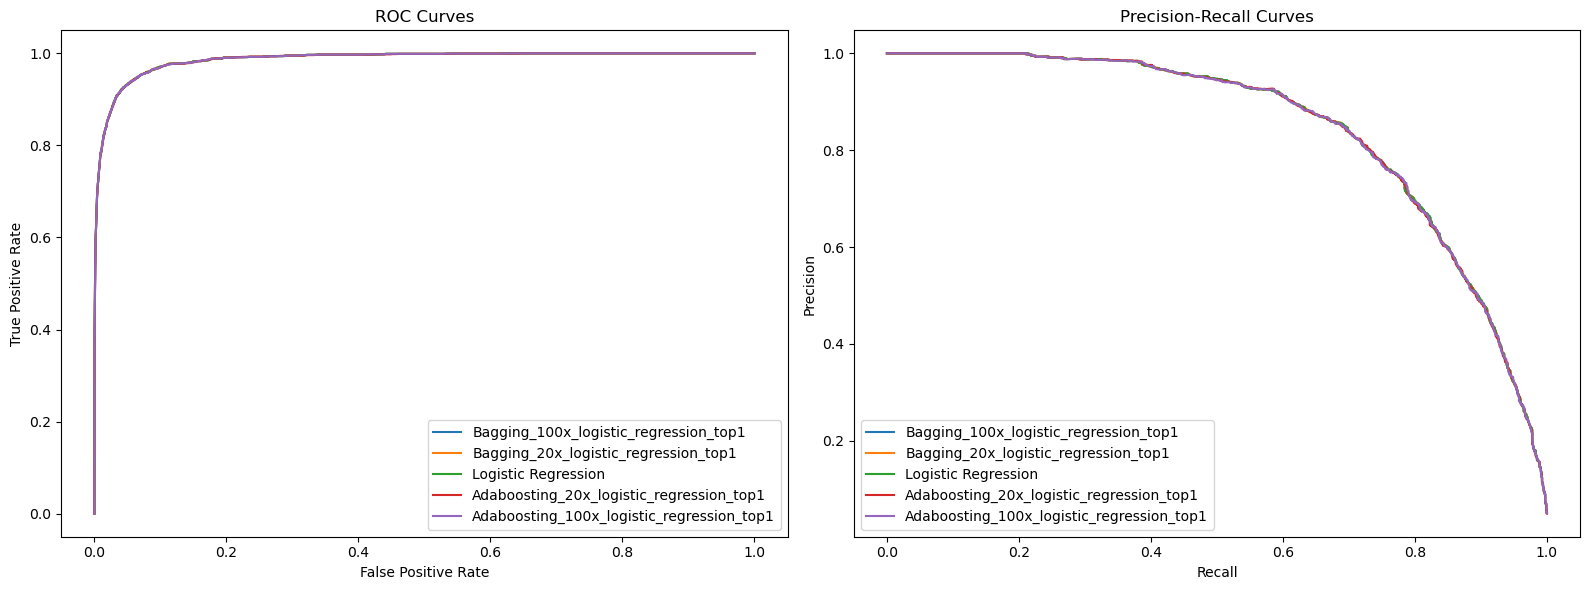

In [41]:
# Select the top 5 models based on F1 Test score
top5_models = sorted(results, key=lambda x: x['F1 Test'], reverse=True)[:5]

plt.figure(figsize=(16, 6))

# ROC Curves
plt.subplot(1, 2, 1)
for model_result in top5_models:
    model_name = model_result['Model']
    model = model_result['Best Model'] # retrieve model
    test_probs = model.predict_proba(X_test)[:, 1] # predict probabilities
    fpr, tpr, _ = roc_curve(Y_test, test_probs) # calculates the false positive rates and true positive rates with the function "roc_curve" (we put use "_" to omit the 3rd output of the function "roc_curve" which is the threshold)
    roc_auc = auc(fpr, tpr) # calculates the area under the ROC Curve (AUC-ROC) using the auc function
    plt.plot(fpr, tpr, label=f'{model_name}') # subplot title

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")

# Precision-Recall Curves
plt.subplot(1, 2, 2)
for model_result in top5_models:
    model_name = model_result['Model']
    model = model_result['Best Model']
    test_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(Y_test, test_probs) # the "_" is to omit the threshold which is the 3rd output of the function precision_recall_curve
    plt.plot(recall, precision, label=f'{model_name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

The 2 graphs show that the 5 methods give very similar results for ROC, precision and recall. For the ROC curve, a perfect model would pass by the top left corner meaning all positives are true positives and negatives are true negatives. We are very close to this. For the precision and recall curve, in general, we want a good balance between those 2. In our case, we want to know if a user will subscribe or not, and this variable is very imbalanced (only few converted users). So we might in that case prefer a good recall than a good precision, meaning we will predict really well that a user subscribe even though precision won't be perfect (we might predict that a user subscribe when it is not). Here, it's just an analysis of profiles of users suscribing so the company won't make money if making false positives. So the best recall obtained is actually with bagging20. 

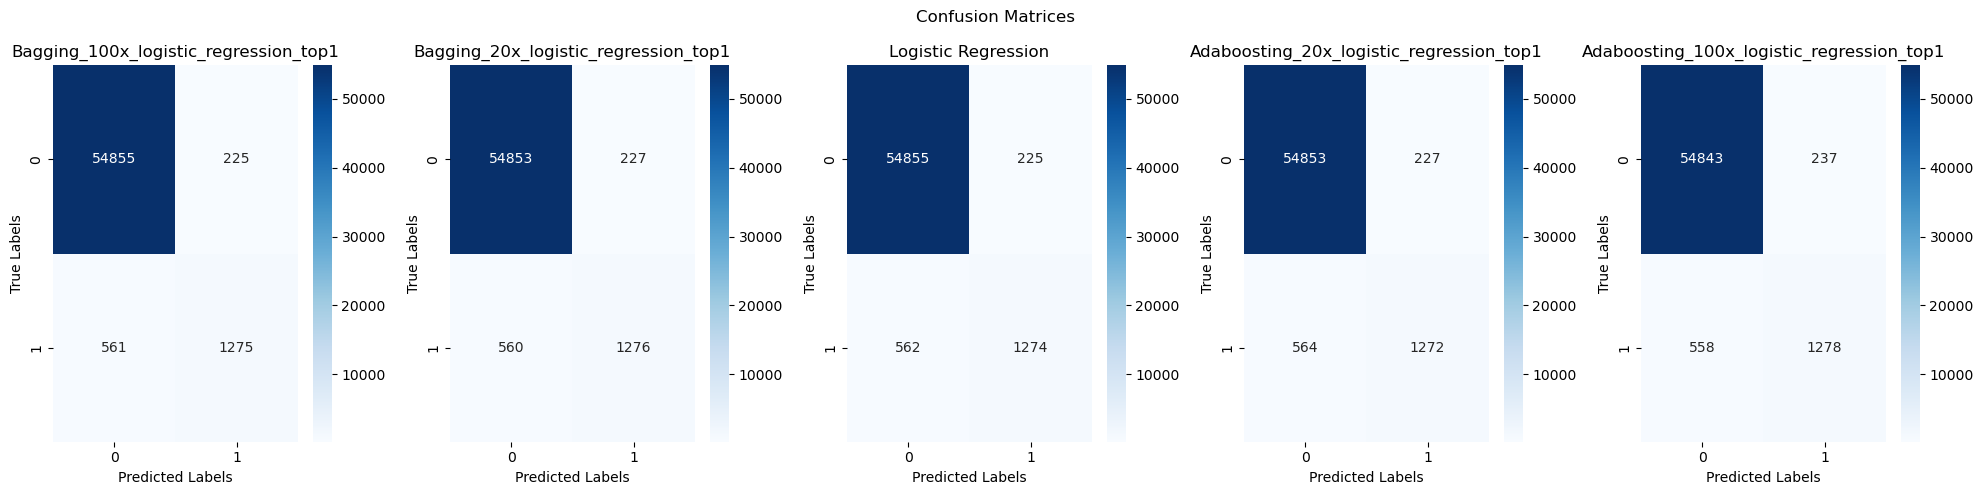

In [44]:
plt.figure(figsize=(20, 5))

# Plot Confusion Matrices
for i, model_result in enumerate(top5_models, 1):
    model_name = model_result['Model']
    test_preds = model_result['Test Preds']
    cm = confusion_matrix(Y_test, test_preds)
    
    plt.subplot(1, 5, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f'{model_name}', fontsize=12) 

plt.suptitle("Confusion Matrices") 
plt.tight_layout()
plt.show()


# Add the test_dataset and make predictions

Finally, the goal of this whole project was to predict another set of data for which we don't have the column of the target. From our dataset, we now we concatenate our train and test set to train the model on a larger set of data, making it more robust. Then we will use the model made to predict the other file.

In [22]:
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

Let's retrieve the best models from the whole project.

In [23]:
top5_models_names = sorted_results_df['Model'].head(5).tolist()
final_results = []

Now, we fit the models on the new larger dataset, retrieve f1 score and other useful metrics. Finally, we take the file "conversion_data_test" that we are asked to predict, preprocess it the same way we did with the train_dataset, then we can apply our model on it and predict the labels. We save all models in the folder "Models/final_models" and all predictions in the folder "Predictions". 

In [ ]:
%%time

for model_name in top5_models_names:
    # Retrieve the model information in the results list
    model_info = next(model for model in results if model['Model'] == model_name)
    best_model = model_info['Best Model']

    # Fit the best model on the new dataset (X, Y)
    best_model.fit(X, Y)

    # Make predictions on the new dataset
    Y_pred = best_model.predict(X)

    # Calculate evaluation metrics on the new dataset and store them
    f1_final = np.round(f1_score(Y, Y_pred), 4)
    accuracy_final = accuracy_score(Y, Y_pred)
    recall_final = recall_score(Y, Y_pred)
    auc_roc_final = roc_auc_score(Y, Y_pred)
    final_results.append({
        'Model': model_name,
        'F1 Score': f1_final,
        'Accuracy': accuracy_final,
        'Recall': recall_final,
        'AUC-ROC': auc_roc_final
    })

    # Saving model
    joblib.dump(best_model, f'Models/final_models/{model_name}.joblib')

    # Predict the the file "conversion_data_test"
    data_without_labels = pd.read_csv('Data/conversion_data_test.csv') # read file
    X_without_labels = data_without_labels.loc[:, features_list].values
    X_without_labels = feature_encoder.transform(X_without_labels) # preprocessing
    data = {'converted': best_model.predict(X_without_labels)} # predict
    Y_predictions = pd.DataFrame(columns=['converted'], data=data) # one column "converted", no index
    prediction_filename = f'Predictions/{model_name}_predictions.csv'
    Y_predictions.to_csv(prediction_filename, index=False) # save into csv file

In [25]:
# Results storage in a DataFrame
final_results_df = pd.DataFrame(final_results)
sorted_final_results_df = final_results_df.sort_values(by='F1 Score', ascending=False)
print(sorted_final_results_df)

                                       Model  F1 Score  Accuracy    Recall  \
4  Adaboosting_100x_logistic_regression_top1    0.7641  0.986208  0.692526   
0      Bagging_100x_logistic_regression_top1    0.7638  0.986239  0.689693   
1       Bagging_20x_logistic_regression_top1    0.7636  0.986232  0.689584   
2                        Logistic Regression    0.7636  0.986236  0.689148   
3   Adaboosting_20x_logistic_regression_top1    0.7632  0.986211  0.689148   

    AUC-ROC  
4  0.844260  
0  0.842907  
1  0.842851  
2  0.842642  
3  0.842630  
